In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
from glob import glob
import sys
from PIL import Image
import pandas as pd
from tqdm import tqdm
import pickle

In [2]:
from model_class import *
from custom_transforms import transform_test
from custom_dataloader import EncodeDataFactory, TripletDataFactory

import torch
from encode_pipeline import *
from utils import visualize_group,export_pickle_file
# from train_pipeline import val_step

/home/taindp/anaconda3/envs/vision/lib/python3.6/site-packages/torchvision/transforms/transforms.py:1322: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


cpu


In [3]:
_MODEL_PATH = '../../model'
_IMG_PATH = '../../data/meta_data'
_RESOURCE_PATH = '../../resource'
_ENCODE_VAL = '../../encode_val'
_ENCODE_FULL = '../../encode_full'

In [4]:
def synthesize_encode(_ENCODE_VAL):
    list_file_enc = glob(os.path.join(_ENCODE_VAL,'*'))
    list_file_enc = sorted(list_file_enc)
    # len(list_file_enc)
    n = 3
    list_file_enc_group = [sorted(list_file_enc[k:k+n]) for k in range(0, len(list_file_enc), n)]
#     list_id = []
    list_path = []
    list_vector = []
    for group in list_file_enc_group:
        _id,path,vector = group
        _id = torch.load(_id).numpy().tolist()
#         list_id += _id
        path = list(torch.load(path))
        list_path += path
        vector = torch.load(vector,map_location=torch.device('cpu'))
        list_vector.append(vector)
    
    full_vector = torch.cat(list_vector,0)
#     print(full_vector.shape)
    
    ## check duplicate
    unique_vector = []
    unique_path = []
    for idx, item in enumerate(list_path):
        if not item in unique_path:
            unique_path.append(item)
            unique_vector.append(full_vector[idx])
    
    return unique_vector,unique_path

In [5]:
vector_val,path_val = synthesize_encode(_ENCODE_VAL)
vector_full,path_full = synthesize_encode(_ENCODE_FULL)

RuntimeError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors.  Available functions are [CPU, QuantizedCPU, BackendSelect, Named, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradNestedTensor, UNKNOWN_TENSOR_TYPE_ID, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].

CPU: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/build/aten/src/ATen/RegisterCPU.cpp:5925 [kernel]
QuantizedCPU: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/build/aten/src/ATen/RegisterQuantizedCPU.cpp:641 [kernel]
BackendSelect: fallthrough registered at /opt/conda/conda-bld/pytorch_1616554793142/work/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Named: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
AutogradOther: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradCPU: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradCUDA: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradXLA: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradNestedTensor: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
UNKNOWN_TENSOR_TYPE_ID: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse1: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse2: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse3: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
Tracer: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/torch/csrc/autograd/generated/TraceType_2.cpp:10525 [kernel]
Autocast: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/aten/src/ATen/autocast_mode.cpp:254 [kernel]
Batched: registered at /opt/conda/conda-bld/pytorch_1616554793142/work/aten/src/ATen/BatchingRegistrations.cpp:1016 [backend fallback]
VmapMode: fallthrough registered at /opt/conda/conda-bld/pytorch_1616554793142/work/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]


In [ ]:
len(vector_full),len(vector_val)

In [25]:
len(path_full),len(path_val)

(15280, 3744)

In [161]:
df_val = pd.read_csv(os.path.join(_RESOURCE_PATH,'df_val.csv'))
# df_val

In [169]:
# list(df_val['product'])

In [175]:
unique_prod_val = list(set(list(df_val['product'])))

# count = 0

for item in unique_prod_val:
    c = list(df_val['product']).count(item)
    if c >= 6:
        count+= 1
count

318

In [27]:
# dict_query = {}
def calculate_query(collection_enc,vector_enc_val,collection_path,path_val,top_k):
    count = 0
    
    list_investigate = []
    total_test = 0
    
    for idx_query, query in tqdm(enumerate(vector_enc_val),total = len(vector_enc_val)):
        dict_investigate = {}
        dict_score = {}
        for idx_pattern, pattern in enumerate(collection_enc):
            score = torch.norm(query - pattern)
            dict_score[idx_pattern] = score
        score_sort = {k: v for k, v in sorted(dict_score.items(), key=lambda item: item[1])}
        top_pattern = list(score_sort.keys())[:top_k]
        if idx_query in top_pattern:
            for _ in range(top_pattern.count(idx_query)):
                del top_pattern[top_pattern.index(idx_query)]

        dict_investigate['test_img'] = path_val[idx_query]
        dict_investigate['query_img'] = [collection_path[item] for item in top_pattern]
        dict_investigate['query_score'] = [score_sort[item] for item in top_pattern]
        list_investigate.append(dict_investigate)
        
    return list_investigate

In [60]:
# list_investigate = calculate_query(vector_full,vector_val,path_full,path_val,10)

In [31]:
export_pickle_file(list_investigate,'../../investigate/evaluation')

export pickle file done


In [32]:
# df_investigate = pd.read_csv('../../investigate/evaluation.csv')
df_investigate = pd.DataFrame(pickle.load(open('../../investigate/evaluation','rb')))

In [33]:
df_investigate

,test_img,query_img,query_score
0,../../data/meta_data/66911001/0.jpg,"[../../data/meta_data/66911001/0.jpg, ../../da...","[tensor(1.1651e-05), tensor(0.0959), tensor(0...."
1,../../data/meta_data/67077697/4.jpg,"[../../data/meta_data/67077697/4.jpg, ../../da...","[tensor(1.0700e-05), tensor(0.1032), tensor(0...."
2,../../data/meta_data/67077697/5.jpg,"[../../data/meta_data/67077697/5.jpg, ../../da...","[tensor(1.0078e-05), tensor(0.1230), tensor(0...."
3,../../data/meta_data/67077697/1.jpg,"[../../data/meta_data/67077697/1.jpg, ../../da...","[tensor(1.1223e-05), tensor(0.1136), tensor(0...."
4,../../data/meta_data/67077697/3.jpg,"[../../data/meta_data/67077697/3.jpg, ../../da...","[tensor(9.8709e-06), tensor(0.1187), tensor(0...."
...,...,...,...
3739,../../data/meta_data/67937612/0.jpg,"[../../data/meta_data/67937612/0.jpg, ../../da...","[tensor(1.1508e-05), tensor(0.1152), tensor(0...."
3740,../../data/meta_data/67937612/1.jpg,"[../../data/meta_data/67937612/1.jpg, ../../da...","[tensor(1.0899e-05), tensor(0.0829), tensor(0...."
3741,../../data/meta_data/67937612/2.jpg,"[../../data/meta_data/67937612/2.jpg, ../../da...","[tensor(1.1336e-05), tensor(0.0857), tensor(0...."
3742,../../data/meta_data/67937612/3.jpg,"[../../data/meta_data/67937612/3.jpg, ../../da...","[tensor(1.0973e-05), tensor(0.1116), tensor(0...."


In [281]:
img = list(df_investigate['test_img'])
query = list(df_investigate['query_img'])
score = list(df_investigate['query_score'])

query_clean = []
score_clean = []
for idx, q in enumerate(query):
    i = img[idx]
    if i in q:
        if q.index(i) == 0:
            query_clean.append(q[1:])
            score_clean.append(score[idx][1:])
        else:
            query_clean.append(q)
            score_clean.append(score[idx])
    else:
        query_clean.append(q)
        score_clean.append(score[idx])
# set(b)-set(a)

In [282]:
df_investigate['query_img']=query_clean
df_investigate['query_score']=score_clean
df_investigate.head()

,test_img,query_img,query_score
0,../../data/meta_data/66911001/0.jpg,"[../../data/meta_data/67334825/1.jpg, ../../da...","[tensor(0.0959), tensor(0.1000), tensor(0.1049..."
1,../../data/meta_data/67077697/4.jpg,"[../../data/meta_data/26345969/3.jpg, ../../da...","[tensor(0.1032), tensor(0.1064), tensor(0.1187..."
2,../../data/meta_data/67077697/5.jpg,"[../../data/meta_data/93271569/0.jpg, ../../da...","[tensor(0.1230), tensor(0.1267), tensor(0.1278..."
3,../../data/meta_data/67077697/1.jpg,"[../../data/meta_data/88928948/9.jpg, ../../da...","[tensor(0.1136), tensor(0.1143), tensor(0.1324..."
4,../../data/meta_data/67077697/3.jpg,"[../../data/meta_data/67077697/4.jpg, ../../da...","[tensor(0.1187), tensor(0.1210), tensor(0.1213..."


In [637]:
def evaluate_top_query(df_investigate,df_val,top_k):
    
    count = 0
    list_manual_check = []
#     list_ = []
    
    unique_prod_val = list(set(list(df_val['product'])))

    # count = 0
    list_prod_evaluation = []
    for item in unique_prod_val:
        c = list(df_val['product']).count(item)
        if c >= 3:
            list_prod_evaluation.append(str(item))
    print(len(list_prod_evaluation))
    amount_eval = 0
    for idx in tqdm(range(len(df_investigate))):
        try:
            
            row = df_investigate.iloc[idx]

            test_img = str(row.test_img)
            
            test_prod = str(test_img.split('/')[-2])
            list_query_img = row.query_img[:top_k]
            list_query_score = row.query_score[:top_k]

            list_query_prod = [str(item.split('/')[-2]) for item in list_query_img]
            
#             print('test_img',test_img)
            if test_prod in list_prod_evaluation:
                
#                 print('>')
                amount_eval += 1
                
                if test_prod in list_query_prod:
                    count += 1
                    list_manual_check.append(idx)
                else:
                    if float(list_query_score[0].item()) <= 1e-3:
                        count += 1
                        list_manual_check.append(idx)
#                     else:
#                         list_manual_check.append(idx)
                    
                list_prod_evaluation.remove(test_prod)
    #                     

        except:
            continue
    recall_at_top = count/amount_eval
    
    return recall_at_top,count,amount_eval,list_manual_check

In [638]:
recall_at_top_1,count_1,amount_eval_1,list_manual_check_1 = evaluate_top_query(df_investigate,df_val,1)

 21%|██        | 783/3744 [00:00<00:00, 7828.09it/s]

517


100%|██████████| 3744/3744 [00:00<00:00, 7918.93it/s]


In [665]:
j-=1

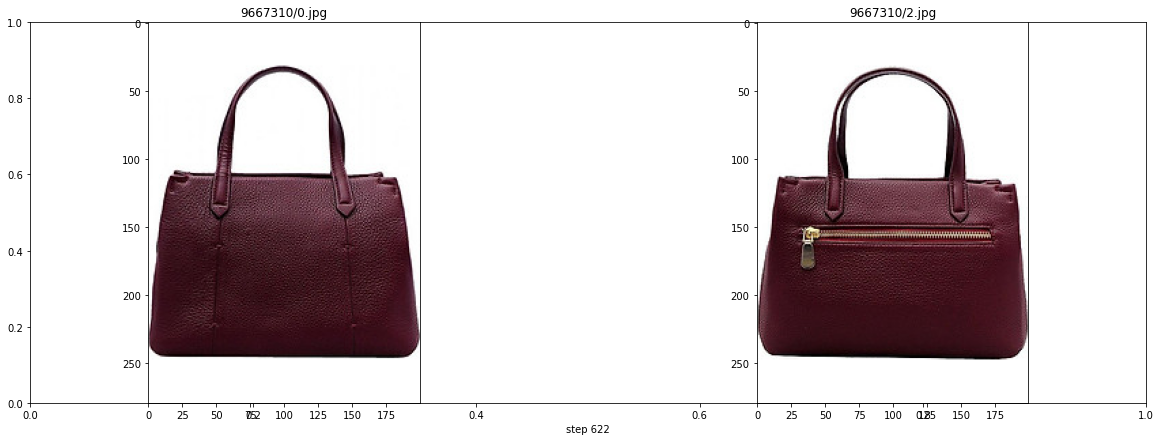

In [669]:
manual_check(df_investigate,list_manual_check_1[j],1)
j+=1

In [640]:
# list_manual_check_1

In [355]:
recall_at_top,count,amount_eval,list_manual_check = evaluate_top_query(df_investigate,df_val,1)

 38%|███▊      | 1409/3744 [00:00<00:00, 7299.29it/s]

517


100%|██████████| 3744/3744 [00:00<00:00, 7297.86it/s]


In [356]:
recall_at_top

0.19922630560928434

In [357]:
count

103

In [358]:
amount_eval

517

In [360]:
len(list_manual_check)

414

In [361]:
def manual_check(df_investigate,idx,top_k):
    row = df_investigate.iloc[idx]
    test_img = row.test_img
    list_query_img = row.query_img[:top_k]
    list_query_score = row.query_score[:top_k]
    visualize_group([test_img]+list_query_img,idx)

In [159]:
# df_val

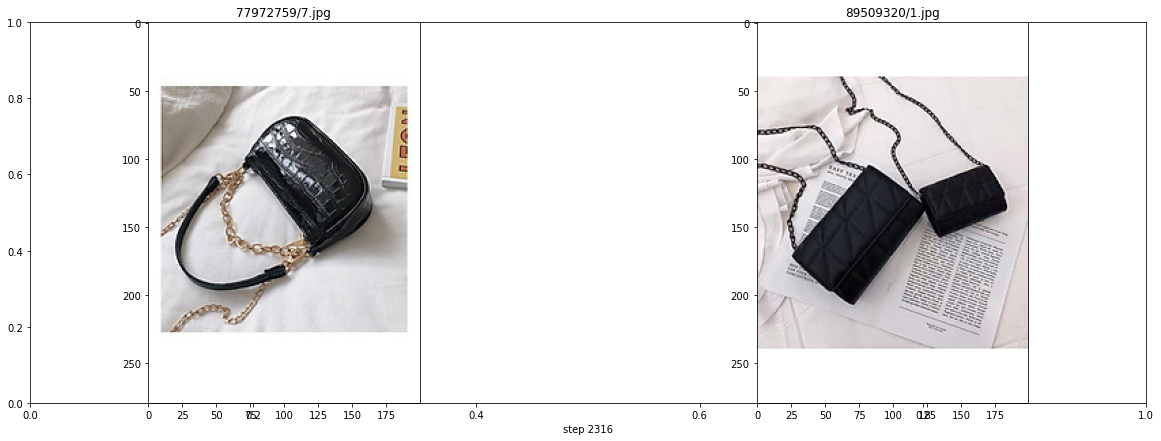

In [634]:
idx = list_manual_check[i]
manual_check(df_investigate,idx,top_k)
i += 1

In [362]:
df_manual_check = pd.DataFrame([])
df_manual_check['idx'] = list_manual_check
df_manual_check['match'] = [0]*len(list_manual_check)
df_manual_check.to_csv('../../investigate/manual_check.csv',index=False,header=True)

In [363]:
i = 0
top_k = 1